# LLM-Powered Booking Analytics & QA System

### Objective
Develop a system that processes hotel booking data, extracts insights, and enables retrieval-augmented question answering (RAG). The system should provide analytics as mentioned in below sections and answer user queries about the dat.

### Contents
- Dataset Loading
- Data Preprocessing
- Data Analysis and Visaulization
- Processed Data CSV Export

**Links:**
- [arindal1 github](www.github.com/arindal1)
- [arindal1 linkedin](www.linkedin.com/in/arindalchar)
- [dataset](https://solvei8-aiml-assignment.s3.ap-southeast-1.amazonaws.com/hotel_bookings.cs)
  a

In [6]:
!pip install pandas numpy matplotlib seaborn fastapi uvicorn sentence-transformers transformers faiss-cpu langchain

## Data Collection and Pre

In [38]:
import pandas as pd
import numpy as np

In [39]:
# Load the dataset
df = pd.read_csv("data/hotel_bookings.csv")

# Display basic info
print("Dataset Shape:", df.shape)
print(df.info())
print(df.head())

Dataset Shape: (119390, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  i

In [40]:
# 1. Convert arrival date columns into a single datetime column.
# Note: 'arrival_date_month' is given as full month name (e.g., "July").

df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_date_month'] + '-' +
    df['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d',
    errors='coerce'  # in case some dates cannot be parsed
)

In [41]:
# 2. Convert reservation_status_date into datetime (assumed format: dd-mm-yy)
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], format='%d-%m-%y', errors='coerce')

In [42]:
# 3. Handle missing values:
#    - For numerical columns like 'children', fill with 0 or median if appropriate.
df['children'] = df['children'].fillna(0)
#    - For 'agent' and 'company', fill missing values with a placeholder (e.g., 0 or "Unknown")
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)
#    - For 'country', fill missing with "Unknown"
df['country'] = df['country'].fillna("Unknown")

In [43]:
# 4. Derive additional columns:
# Total number of nights stayed (week + weekend)
df['total_stays'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

In [44]:
# Calculate estimated revenue:
# Revenue = adr * total nights stayed.
# (Assuming each booking's revenue is approximated by the average daily rate times total nights.)
df['revenue'] = df['adr'] * df['total_stays']

In [45]:
# Display the updated dataframe structure
print("\nPreprocessed Data:")
print(df[['arrival_date', 'reservation_status_date', 'total_stays', 'revenue']].head())


Preprocessed Data:
  arrival_date reservation_status_date  total_stays  revenue
0   2015-07-01              2015-07-01            0      0.0
1   2015-07-01              2015-07-01            0      0.0
2   2015-07-01              2015-07-02            1     75.0
3   2015-07-01              2015-07-02            1     75.0
4   2015-07-01              2015-07-03            2    196.0


In [46]:
# Function to determine season based on the month (assuming northern hemisphere)
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply function to create a new 'season' column (ensure arrival_date is in datetime format)
df['season'] = df['arrival_date'].apply(lambda x: get_season(x) if pd.notnull(x) else 'Unknown')

# Verify the new feature
print("Season distribution:")
print(df['season'].value_counts())

Season distribution:
season
Summer    37477
Spring    32674
Autumn    28462
Winter    20777
Name: count, dtype: int64


## Analytics and Visualization

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

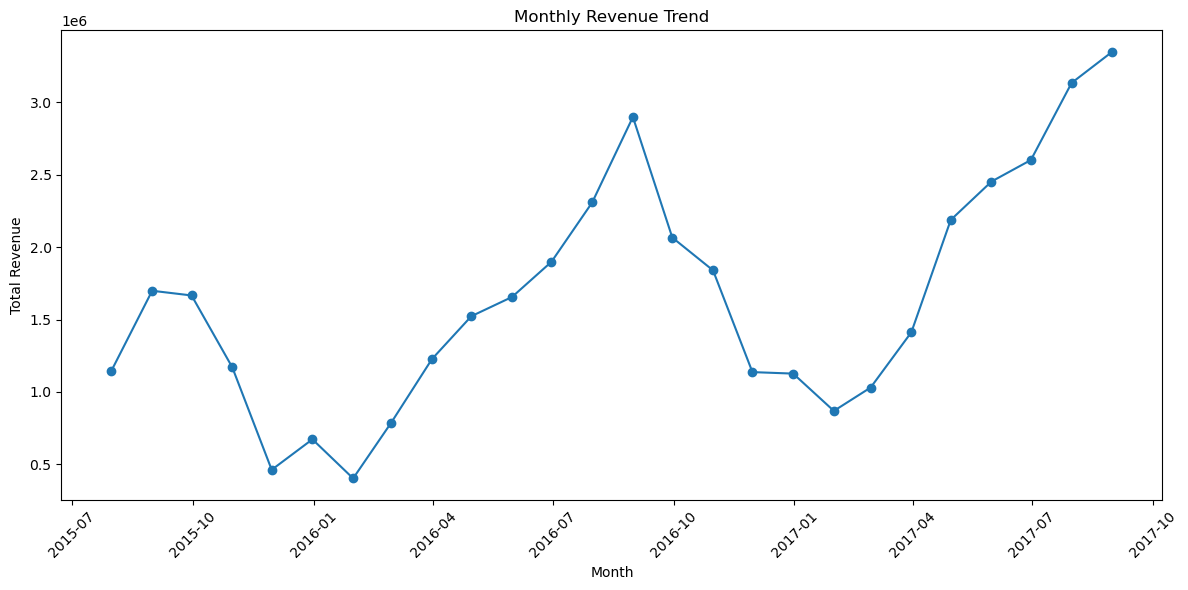

In [48]:
# Group by arrival_date (monthly)
revenue_trend = df.groupby(pd.Grouper(key='arrival_date', freq='M'))['revenue'].sum()

plt.figure(figsize=(12, 6))
plt.plot(revenue_trend.index, revenue_trend.values, marker='o')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
# is_canceled: 1 means canceled, 0 means not canceled.
total_bookings = len(df)
total_cancellations = df['is_canceled'].sum()
cancellation_rate = (total_cancellations / total_bookings) * 100

print(f"Overall Cancellation Rate: {cancellation_rate:.2f}%")

Overall Cancellation Rate: 37.04%


C:\Users\Arindal Char\AppData\Local\Temp\ipykernel_15688\2707114378.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index[:10], y=country_counts.values[:10], palette='viridis')


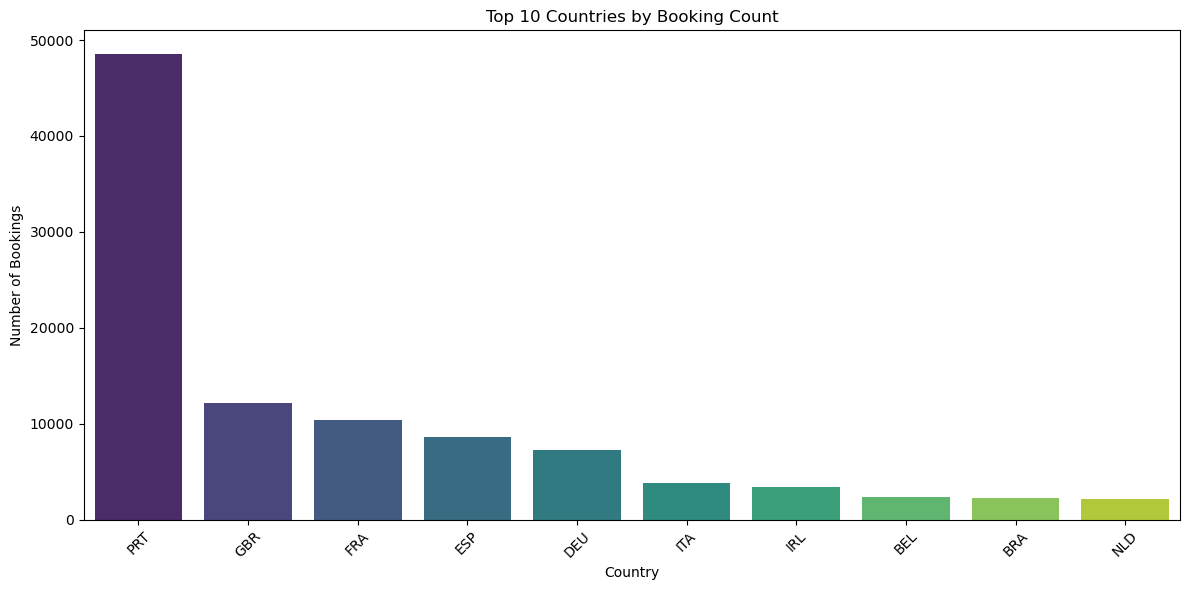

In [50]:
# Count bookings per country
country_counts = df['country'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts.index[:10], y=country_counts.values[:10], palette='viridis')
plt.title('Top 10 Countries by Booking Count')
plt.xlabel('Country')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

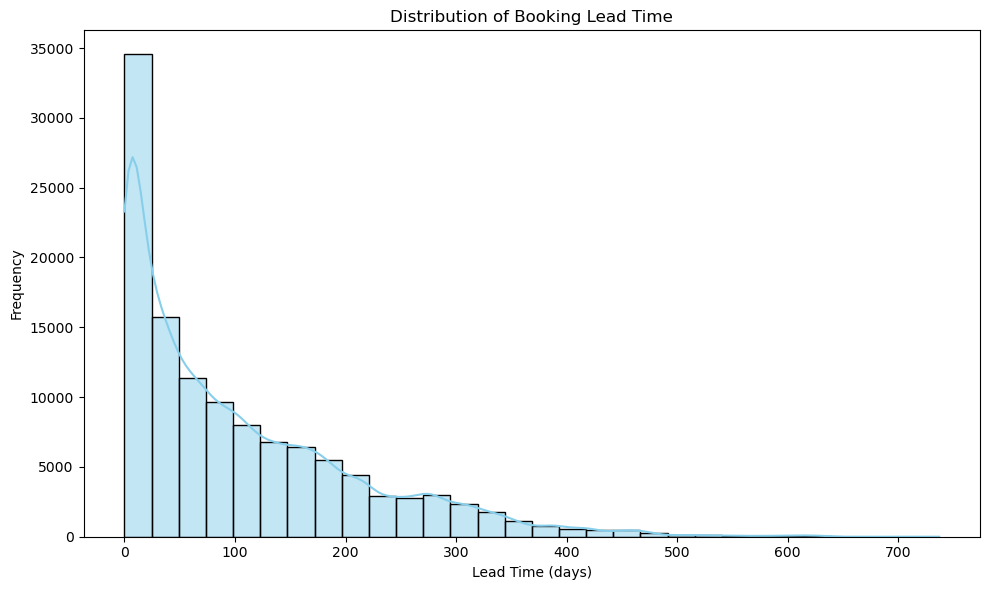

In [51]:
# Histogram of the lead times.

plt.figure(figsize=(10, 6))
sns.histplot(df['lead_time'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Booking Lead Time')
plt.xlabel('Lead Time (days)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [52]:
# Cap the ADR to a maximum value (optional, adjust threshold as per domain knowledge)
adr_cap = 1000
df['adr_capped'] = df['adr'].apply(lambda x: min(x, adr_cap))

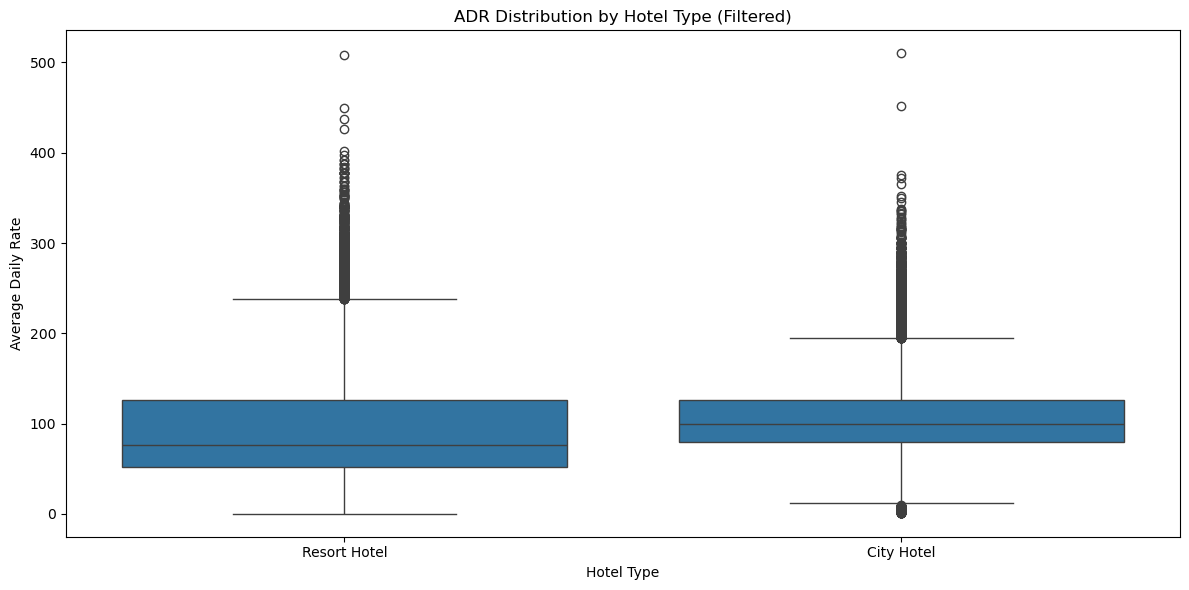

In [53]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='hotel', y='adr', data=df_filtered)
plt.title('ADR Distribution by Hotel Type (Filtered)')
plt.xlabel('Hotel Type')
plt.ylabel('Average Daily Rate')
plt.tight_layout()
plt.show()

Average Revenue by Customer Type:
customer_type
Contract           451.196700
Transient          381.631057
Transient-Party    260.493376
Group              243.813328
Name: revenue, dtype: float64


C:\Users\Arindal Char\AppData\Local\Temp\ipykernel_15688\282020276.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_revenue_by_customer.index, y=avg_revenue_by_customer.values, palette='magma')


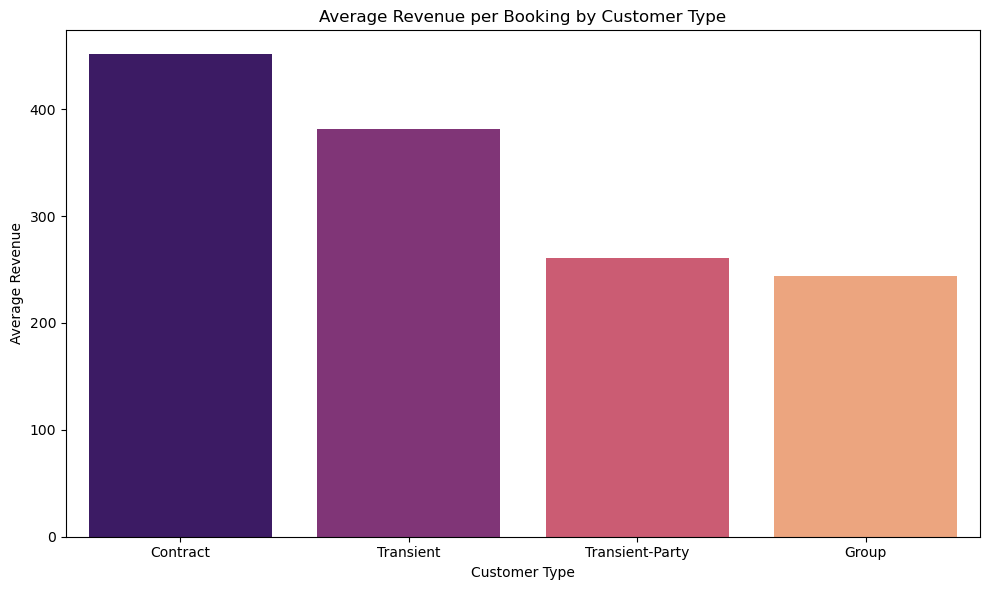

In [54]:
# Average Revenue per Booking by Customer Type

# Group by customer_type and calculate average revenue
avg_revenue_by_customer = df.groupby('customer_type')['revenue'].mean().sort_values(ascending=False)
print("Average Revenue by Customer Type:")
print(avg_revenue_by_customer)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_revenue_by_customer.index, y=avg_revenue_by_customer.values, palette='magma')
plt.title('Average Revenue per Booking by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Average Revenue')
plt.tight_layout()
plt.show()

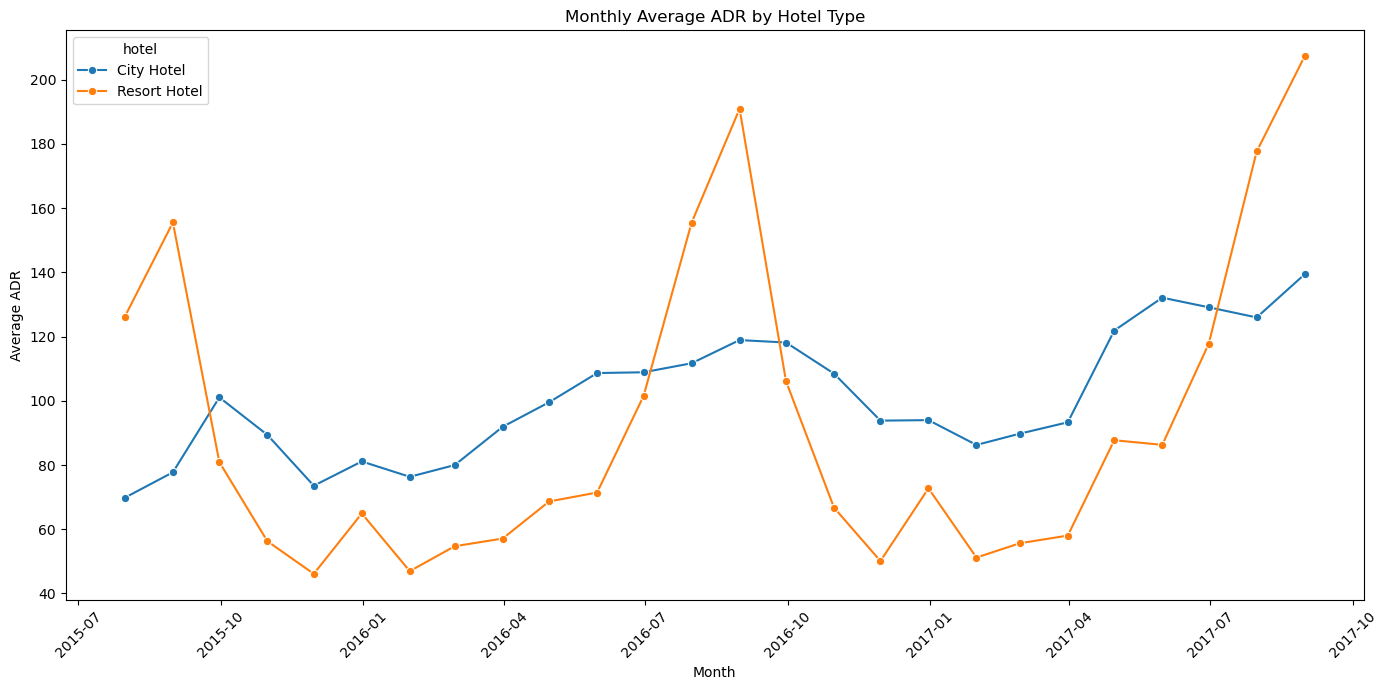

In [55]:
# Group by month and hotel type to calculate mean ADR
adr_trend_hotel = df.groupby([pd.Grouper(key='arrival_date', freq='M'), 'hotel'])['adr'].mean().reset_index()

plt.figure(figsize=(14,7))
sns.lineplot(data=adr_trend_hotel, x='arrival_date', y='adr', hue='hotel', marker='o')
plt.title('Monthly Average ADR by Hotel Type')
plt.xlabel('Month')
plt.ylabel('Average ADR')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

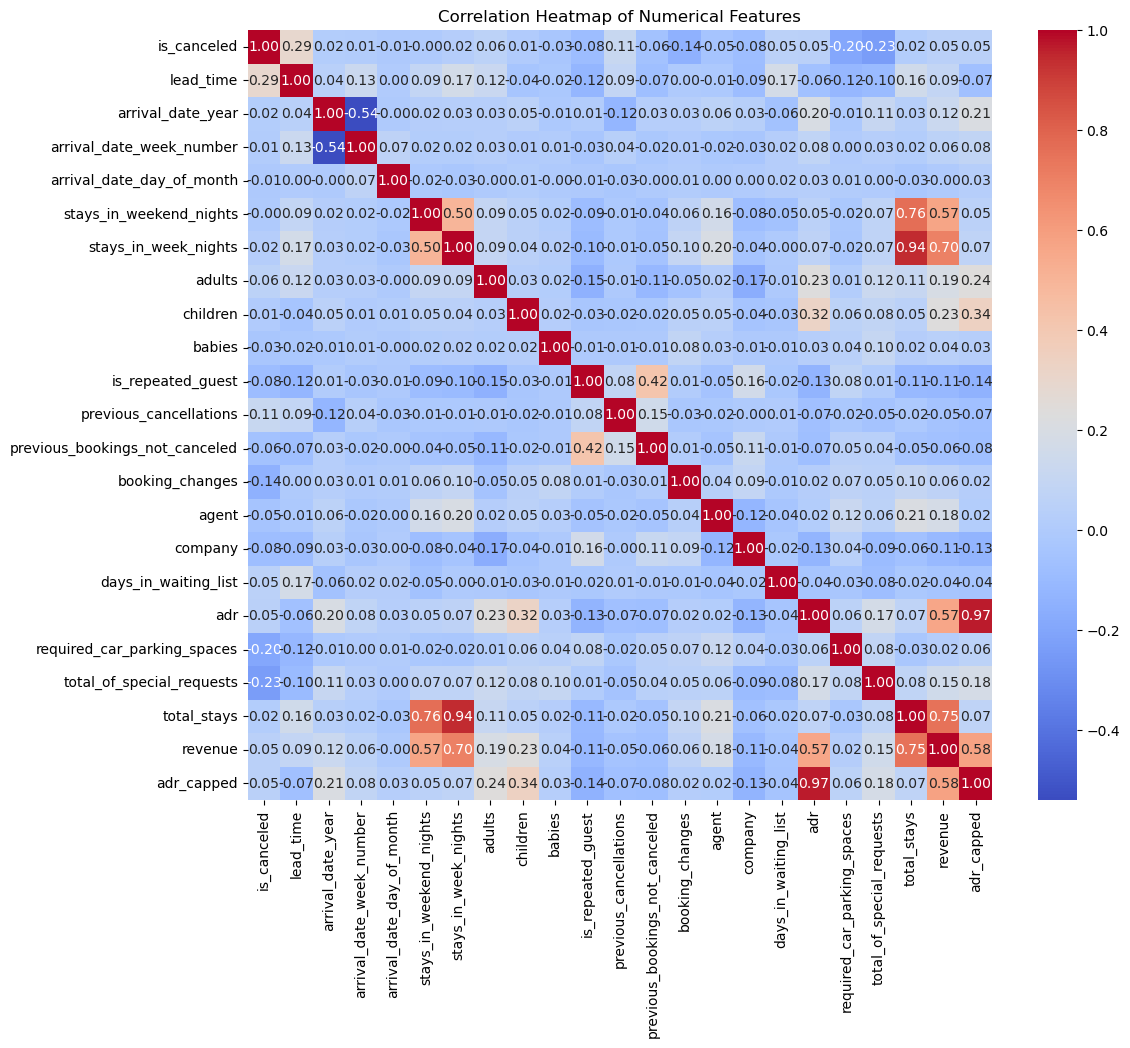

In [56]:
# Correlation Heatmap of Numerical Features
numeric_cols = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

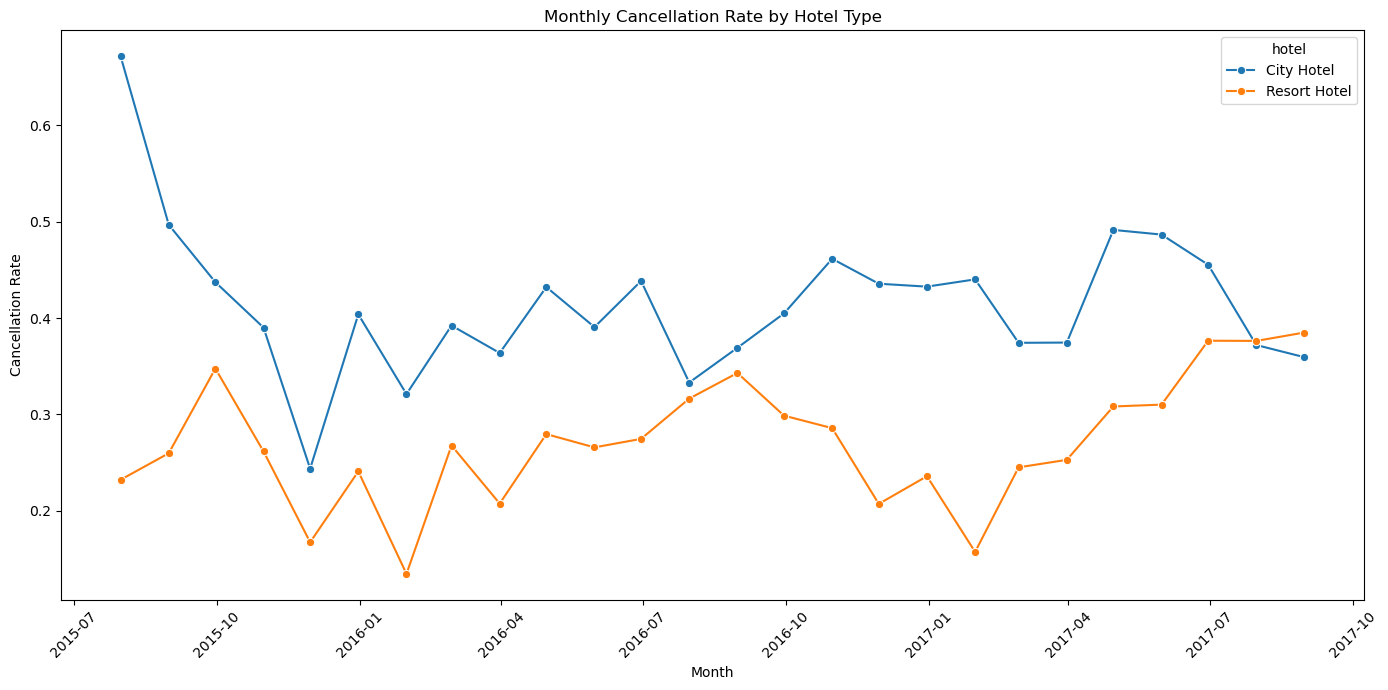

In [57]:
# Cancellation Rate by Month and Hotel Type

# Calculate monthly cancellation rate per hotel type (is_canceled is 1 for canceled, 0 for not canceled)
cancellation_by_month_hotel = df.groupby([pd.Grouper(key='arrival_date', freq='M'), 'hotel'])['is_canceled'].mean().reset_index()

plt.figure(figsize=(14,7))
sns.lineplot(data=cancellation_by_month_hotel, x='arrival_date', y='is_canceled', hue='hotel', marker='o')
plt.title('Monthly Cancellation Rate by Hotel Type')
plt.xlabel('Month')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Average Revenue by Season:
season
Summer    507.826623
Spring    320.065285
Autumn    293.079306
Winter    235.464351
Name: revenue, dtype: float64


C:\Users\Arindal Char\AppData\Local\Temp\ipykernel_15688\586029692.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_revenue_by_season.index, y=avg_revenue_by_season.values, palette='viridis')


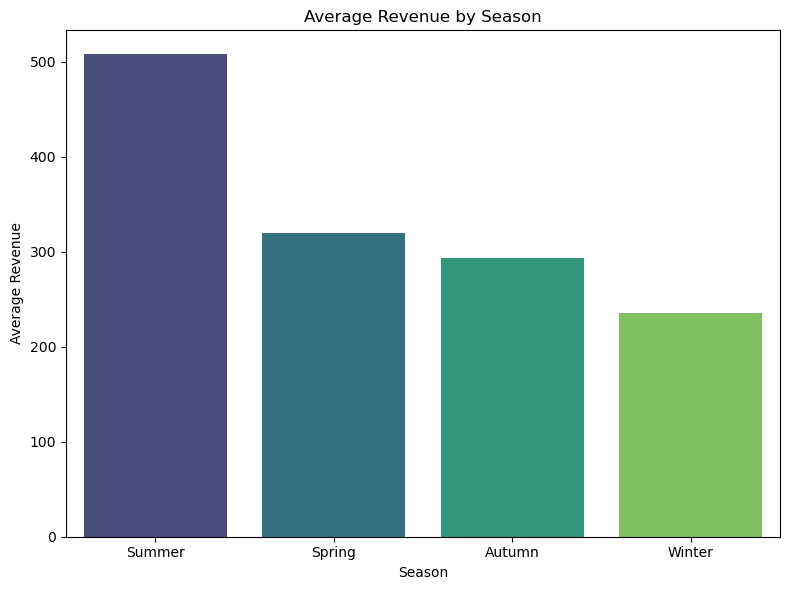

In [58]:
# Average Revenue by Season

# Group by the new 'season' column and calculate average revenue
avg_revenue_by_season = df.groupby('season')['revenue'].mean().sort_values(ascending=False)
print("Average Revenue by Season:")
print(avg_revenue_by_season)

plt.figure(figsize=(8,6))
sns.barplot(x=avg_revenue_by_season.index, y=avg_revenue_by_season.values, palette='viridis')
plt.title('Average Revenue by Season')
plt.xlabel('Season')
plt.ylabel('Average Revenue')
plt.tight_layout()
plt.show()

---

## Export Processed Data

In [59]:
df.to_csv("hotel_bookings_preprocessed.csv", index=False)